In [6]:
# Import libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

Load Dataset and Pretrained model/tokenizer

In [9]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")      # Load text data from the Wikitext-2 dataset.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()                                   # Load pretrained BERT tokenizer and model (bert-base-uncased), set to evaluation mode.

texts = [t for t in dataset['text'] if t.strip()][:100]                  # Take first non empty 100 texts
embeddings = []
with torch.no_grad():
    for text in texts:
        if not text.strip():
            continue
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

X = np.stack(embeddings)
print(f"Shape of input matrix X: {X.shape}")  # Shape of input matrix X: (100, 768)
print(f"First 5 rows of X:\n{X[:5]}")  # Print first 5 rows of X

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Shape of input matrix X: (100, 768)
First 5 rows of X:
[[-0.37750903 -0.09930224  0.1452676  ... -0.39746624  0.6287987
   0.45260218]
 [ 0.0488951  -0.725698   -0.11117578 ...  0.6213883   0.7880728
  -0.15260921]
 [-0.56505805 -1.3505775  -0.00995144 ...  0.05098987  0.6561996
   0.27877066]
 [-0.16776226 -0.7639402   0.12694797 ...  0.24344985  0.5024259
  -0.01309569]
 [-0.18117005  0.3032792   0.21510303 ... -0.5089509   0.05674721
   0.72851837]]


In [10]:
def construct_hankel_matrix(T):
    # Construct the hankel matirx Z
    Z = np.zeros((T, T))
    for i in range(T):
        for j in range(T):
            Z[i, j] = 2 / (((i + j + 2)**3) - (i + j + 2))

        # Compute eigenvalues and eigenvectors of Z
    eigvals, eigvecs = np.linalg.eigh(Z)
    pairs = sorted(zip(eigvals, eigvecs.T), key=lambda x: -x[0])
    eigvals = np.array([p[0] for p in pairs])
    eigvals = np.clip(eigvals, 1e-12, None)
    eigvecs = np.column_stack([p[1] for p in pairs])
    return eigvals, eigvecs
    

def spectral_basis(X, k, eigvals, eigvecs):
    """
    Given input stream X, computes the spectral filtered input matrix.
    
    ARGS:
        X ∈ ℝ^{T×d_in}     (inputs)
        k      : int       (Number of basis functions to use)
    Returns:
        Phi(X) ∈ ℝ^{T×k*d_in}  (filtered inputs)
    """
    T = X.shape[0]
    d_in = X.shape[1]

    # Filter inputs X and return Phi(X)
    phis = eigvecs[:, :k]  # use the first k eigenvectors
    Phi = np.zeros((T, k*d_in))
    for j in range(k):
        # causal convolution for all input dims at once
        conv = np.apply_along_axis(
            lambda x: np.convolve(x, phis[:, j], mode="full")[:T],
            axis=0,
            arr=X
        )                               # shape (T, d_in)
        Phi[:, j*d_in:(j+1)*d_in] = (eigvals[j] ** 0.25) * conv

    return Phi

Plotting Results

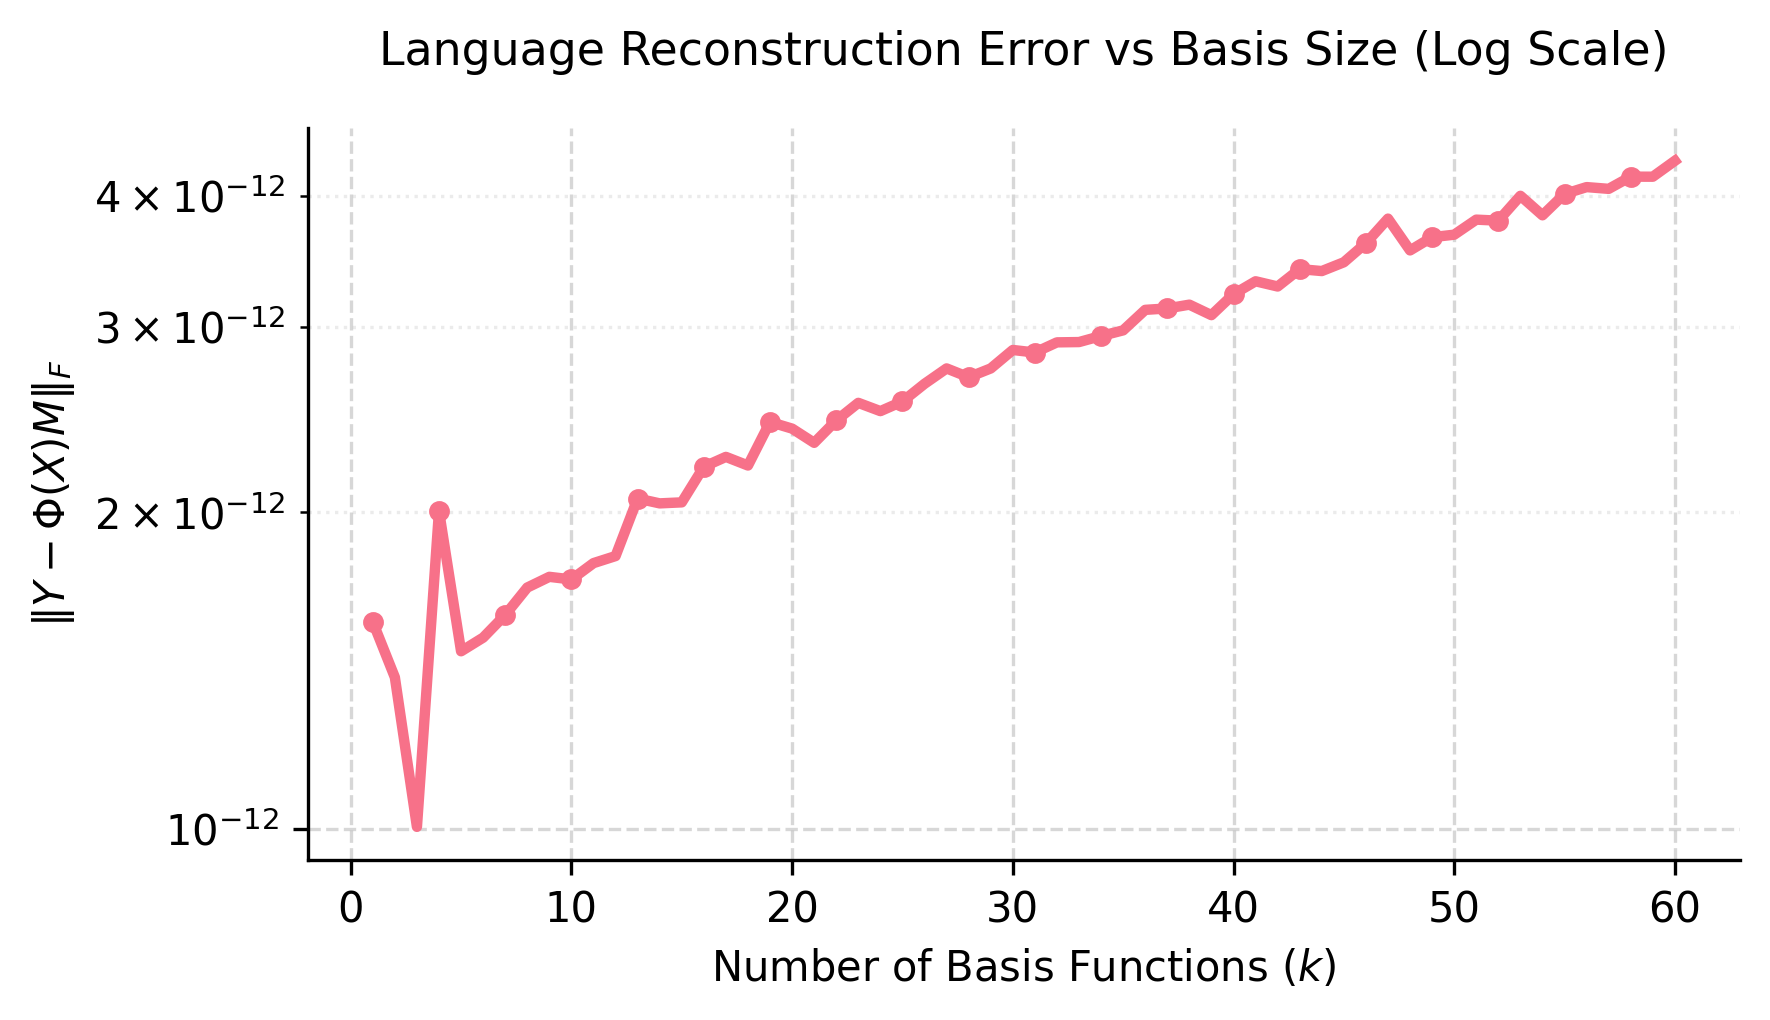

In [15]:
eigvals, eigvecs = construct_hankel_matrix(X.shape[0])
ks = np.arange(1, 61)
errs = []
for k_i in ks:
    T_data = X.shape[0]
    Phi = spectral_basis(X, k=k_i, eigvals=eigvals, eigvecs=eigvecs)  # Generate basis with matching time dimension
    M, _, _, _ = np.linalg.lstsq(Phi, X, rcond=None)  # k_i x d # Learn an M that is kxd that projects via linear regression fit
    errs.append(np.linalg.norm(X - Phi @ M, ord='fro'))

plt.figure(figsize=(6, 3.5), dpi=300)
plt.plot(ks, errs, lw=2.5, color=sns.color_palette("husl", 10)[0], label="Spectral Basis", marker='o', markersize=4, markevery=3)
plt.yscale("log")
plt.ylabel(r"$\| Y - \Phi(X) M \|_F$", fontsize=10)
plt.xlabel(r"Number of Basis Functions ($k$)", fontsize=10)
plt.title("Language Reconstruction Error vs Basis Size (Log Scale)", fontsize=11, pad=15)
plt.grid(True, which="major", linestyle="--", alpha=0.5)
plt.grid(True, which="minor", linestyle=":", alpha=0.25)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()